# Predict stock prices using RNNs
~~Based on Lilan Weng's [blog post](https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html)~~
* ~~[*her code*](https://github.com/lilianweng/stock-rnn)~~

~~Now following [this](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/) tutorial~~

Actually [this](https://www.youtube.com/watch?v=arydWPLDnEc) one

### Variables
* ${W_i}$: Window i
* ${w}$: size of windows 
* ${p_i}$: stock price at end of day i


**Predict:** ${W_{t+1}}$
* where ${W_{t+1}} = (p_{(t+1)w}, p_{(t+1)w+1}, ..., p_{(t+2)w-1})$
* and ${W_{t}} = (p_{tw}, p_{tw+1}, ..., p_{(t+1)w-1})$

i.e., we learn a function $f(W_0, ..., W_t) \approx W_{t+1}$

**RNN:**
![](imgs/unrolled_RNN.png)

* `input_size`: number of timesteps (days) in a window
* `num_steps`: number of windows in a single training ex 

## 1 - Fetching and formatting the data
### 1.1 - Fetching
The [pandas](https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html) library is used for data access / manipulation

In [29]:
import click
import os
import pandas as pd
import random
import time
import urllib
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

#from BeautifulSoup import BeautifulSoup
from datetime import datetime

#np.version.version
#print(tf.__version__)

In [1]:
def get_csv():
    df = pd.read_csv("../data/_SP500.csv")
    #df['Close'].plot().set_ylabel("Stock price ($)")
    return df

In [24]:
df = get_csv()
df
#df['Close']

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1,1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
2,1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
3,1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
4,1950-01-09,17.090000,17.090000,17.080000,17.080000,17.080000,3850000
...,...,...,...,...,...,...,...
16974,2017-06-19,2442.550049,2453.820068,2441.790039,2453.459961,2453.459961,3264700000
16975,2017-06-20,2450.659912,2450.659912,2436.600098,2437.030029,2437.030029,3416510000
16976,2017-06-21,2439.310059,2442.229980,2430.739990,2435.610107,2435.610107,3594820000
16977,2017-06-22,2437.399902,2441.620117,2433.270020,2434.500000,2434.500000,3468210000


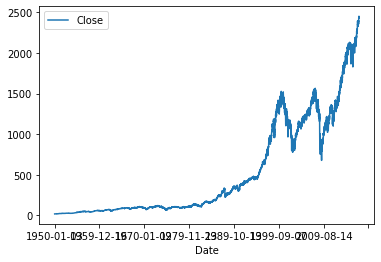

In [25]:
df.plot(x='Date', y='Close')

In [27]:
# split data into *discrete* contiguous windows
# TODO: will this have to be modified to accommodate (n,m) sequences rather than univariate?
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # end of window
        end_ix = i + n_steps
        